In [ ]:
# pip install pandas groq matplotlib

In [102]:
import pandas as pd
from groq import Groq
import matplotlib.pyplot as plt
import re

In [ ]:
# Change API key / Enter Your API Key
client = Groq(api_key=" ")

In [ ]:
# Pre-processing the data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)

df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)
df = df.set_index('datetime')


C:\Users\Jeet\AppData\Local\Temp\ipykernel_31028\3609433623.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
C:\Users\Jeet\AppData\Local\Temp\ipykernel_31028\3609433623.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',
C:\Users\Jeet\AppData\Local\Temp\ipykernel_31028\3609433623.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt',


In [ ]:
# Giving LLM Context of CSV File Data
DATA_CONTEXT = """
You are working with a pandas DataFrame named df. 
- It has a datetime index (from merging Date and Time columns) and these columns:
Global_active_power (float), Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3.
Missing values have been dropped and Global_active_power is float.

When working with dates:
- Use .loc['YYYY-MM-DD'] for date filtering
- Access datetime components via .index.component (e.g .index.hour)
- Never create new datetime objects from strings

When filtering time series data:
- First resample to the desired frequency
- Create filters directly from the resampled Series
- Never mix indices from different frequencies

"""
# Cleaning LLM Response Code
def clean_code(code):
    
    return re.sub(r"^```.*$", "", code, flags=re.MULTILINE).strip()

# Function To Execute Code
def generate_and_execute(prompt):
    full_prompt = f"{DATA_CONTEXT}\n\n{prompt}\nReturn only the Python code, no explanation."
    response = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[{"role": "user", "content": full_prompt}],
        temperature=0.2
    )
    code = response.choices[0].message.content
    print("Generated code:\n", code)
    cleaned_code = clean_code(code)
    exec(cleaned_code, globals())


In [ ]:
# March 2007 Average
generate_and_execute(
    "Calculate and print the single average value of Global_active_power for all rows in March 2007 (not per day, but for the entire month as a single value)."
)


Generated code:
 ```python
average_power = df.loc['2007-03-01':'2007-03-31'].resample('1min').mean().loc['2007-03-01':'2007-03-31'].Global_active_power.mean()
print(average_power)
```
1.318627030175407


In [ ]:
# Highest Hour Consumption on Christmas
generate_and_execute(
    "Find hour with highest power usage on 25-12-2006"
    "using index-based datetime operations"
)


Generated code:
 ```python
hourly_power = df.loc['2006-12-25'].resample('1h').mean()['Global_active_power']
max_power_hour = hourly_power.idxmax()
print(df.loc[max_power_hour])
```
Global_active_power        3.600
Global_reactive_power      0.196
Voltage                  236.460
Global_intensity          15.600
Sub_metering_1             2.000
Sub_metering_2            17.000
Sub_metering_3            17.000
Name: 2006-12-25 22:00:00, dtype: float64


In [ ]:
# Mean Active Power on weekdays vs weekends
generate_and_execute(
    "Compare mean Global_active_power between weekdays and weekends. Print the results."
)


Generated code:
 ```python
# Resample data to daily frequency
daily_df = df.resample('D').mean()

# Filter weekdays and weekends
weekdays = daily_df.loc[daily_df.index.weekday < 5]['Global_active_power']
weekends = daily_df.loc[daily_df.index.weekday >= 5]['Global_active_power']

# Print the results
print('Mean Global_active_power on weekdays:', weekdays.mean())
print('Mean Global_active_power on weekends:', weekends.mean())
```
Mean Global_active_power on weekdays: 1.0366861398387823
Mean Global_active_power on weekends: 1.2311321638722603


Generated code:
 ```python
import matplotlib.pyplot as plt

# Filter the first week of January 2007
df_first_week = df.loc['2007-01-01':'2007-01-07']

# Resample to daily frequency
df_resampled_daily = df_first_week.resample('D').mean()

# Plot the Global_active_power trend
plt.figure(figsize=(10,6))
plt.plot(df_resampled_daily.index, df_resampled_daily['Global_active_power'], label='Global_active_power')
plt.title('Global_active_power Trend for the First Week of January 2007')
plt.xlabel('Date')
plt.ylabel('Global_active_power (kW)')
plt.legend()
plt.show()
```


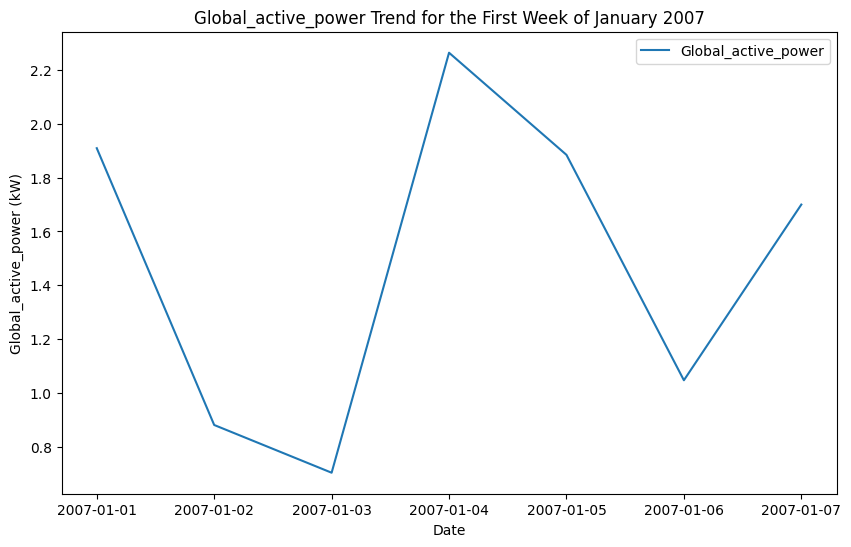

In [ ]:
# Plotting Active Power Trend for first week of January
generate_and_execute(
    "Plot the Global_active_power trend for the first week of January 2007 using matplotlib. Include title and axis labels."
)
plt.show()


In [ ]:
# Dates where daily energy consumption exceeds 5 kWh 
generate_and_execute(
    "Calculate the daily total energy consumption in kWh by converting each Global_active_power reading (in kW, sampled every minute) to kWh, then sum per day. Print all dates where the daily energy exceeds 5 kWh"
)


Generated code:
 ```python
# Resample to daily frequency and calculate daily total energy consumption in kWh
daily_energy = df['Global_active_power'].resample('D').sum() * 60  # convert kW to kWh

# Print all dates where the daily energy exceeds 5 kWh
print(daily_energy[daily_energy > 5].index)
```
DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='datetime', length=1433, freq=None)


In [ ]:
# Average Voltage for each day in first week of Feb 2007
generate_and_execute(
    "Calculate the average Voltage for each day of the first week of February 2007 and print the results. Using index-based datetime operations"
)


Generated code:
 ```python
# Resample to daily frequency and calculate average Voltage
daily_avg_voltage = df.resample('D').mean().loc['2007-02-01':'2007-02-07']['Voltage']

# Print the results
print(daily_avg_voltage)
```
datetime
2007-02-01    240.392139
2007-02-02    240.334389
2007-02-03    238.910194
2007-02-04    239.633333
2007-02-05    240.810312
2007-02-06    241.264160
2007-02-07    241.149694
Freq: D, Name: Voltage, dtype: float64


In [ ]:
# Correlation Matrix
generate_and_execute(
    "Calculate and print the correlation matrix between Global_active_power and the three Sub_metering columns."
)


Generated code:
 ```python
import pandas as pd
import numpy as np

# Resample the data to daily frequency
daily_df = df.resample('D').mean()

# Calculate the correlation matrix
corr_matrix = daily_df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()

# Print the correlation matrix
print(corr_matrix)
```
                     Global_active_power  Sub_metering_1  Sub_metering_2  \
Global_active_power             1.000000        0.541115        0.474655   
Sub_metering_1                  0.541115        1.000000        0.249159   
Sub_metering_2                  0.474655        0.249159        1.000000   
Sub_metering_3                  0.728800        0.301549        0.196551   

                     Sub_metering_3  
Global_active_power        0.728800  
Sub_metering_1             0.301549  
Sub_metering_2             0.196551  
Sub_metering_3             1.000000  
